In [1388]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as ticker # type: ignore
from matplotlib.axis import Axis # type: ignore
import datetime as dt 

import time
start = time.time()

In [1389]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # type: ignore # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [1390]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2116750 entries, 0 to 2116749
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 32.3 MB


# reduce to 1 million events

In [1391]:
conso_data = conso_data.tail(1000000)
conso_data.reset_index(drop=True, inplace=True)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Interval  1000000 non-null  int64  
 1   kWh       1000000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 15.3 MB


### conversion Interval -> kWh

In [1392]:
conso_data['sec']=conso_data['Interval']/1000
conso_data

,Interval,kWh,sec
0,28184,0.13,28.184
1,28155,0.13,28.155
2,28124,0.13,28.124
3,28416,0.13,28.416
4,28973,0.12,28.973
...,...,...,...
999995,22811,0.16,22.811
999996,22358,0.16,22.358
999997,21289,0.17,21.289
999998,21356,0.17,21.356


In [1393]:
conso_data['Wh']=3600000/conso_data['Interval']


### Cumul Total interval

In [1394]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [1395]:
l=len(conso_data)-1
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

26154268251000

### Calcul de la date de base = now - cumul_interval

In [1396]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2024, 6, 15, 4, 11, 2, 148404)

In [1397]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [1398]:
conso_data.iloc[0]


Interval     28184.000000
kWh              0.130000
sec             28.184000
Wh             127.732047
cumul(ms)    28184.000000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [1399]:
base

datetime.datetime(2024, 6, 15, 4, 11, 2, 148404)

## créer les dates

In [1400]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0        2024-06-15 04:11:30.332404
1        2024-06-15 04:11:58.487404
2        2024-06-15 04:12:26.611404
3        2024-06-15 04:12:55.027404
4        2024-06-15 04:13:24.000404
                    ...            
999995   2025-04-13 21:14:02.992404
999996   2025-04-13 21:14:25.350404
999997   2025-04-13 21:14:46.639404
999998   2025-04-13 21:15:07.995404
999999   2025-04-13 21:15:30.399404
Name: dates, Length: 1000000, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [1401]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,28184,0.13,28.184,127.732047,28184,2024-06-15 04:11:30.332404,15/06/24
1,28155,0.13,28.155,127.863612,56339,2024-06-15 04:11:58.487404,15/06/24
2,28124,0.13,28.124,128.004551,84463,2024-06-15 04:12:26.611404,15/06/24
3,28416,0.13,28.416,126.689189,112879,2024-06-15 04:12:55.027404,15/06/24
4,28973,0.12,28.973,124.253615,141852,2024-06-15 04:13:24.000404,15/06/24
...,...,...,...,...,...,...,...
999995,22811,0.16,22.811,157.818596,26154180844,2025-04-13 21:14:02.992404,13/04/25
999996,22358,0.16,22.358,161.016191,26154203202,2025-04-13 21:14:25.350404,13/04/25
999997,21289,0.17,21.289,169.101414,26154224491,2025-04-13 21:14:46.639404,13/04/25
999998,21356,0.17,21.356,168.570893,26154245847,2025-04-13 21:15:07.995404,13/04/25


### save conso_data with dates

In [1402]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [1403]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
here = now.strftime('%H:%M:%S')
today, date, month, year, here

('13/04/25', 13, 4, 2025, '21:15:51')

In [1404]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [1405]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3066 entries, 996934 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   3066 non-null   int64         
 1   kWh        3066 non-null   float64       
 2   sec        3066 non-null   float64       
 3   Wh         3066 non-null   float64       
 4   cumul(ms)  3066 non-null   int64         
 5   dates      3066 non-null   datetime64[ns]
 6   days       3066 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 191.6+ KB


In [1406]:
end = time.time()
print(end - start)

25.567995071411133


### grouped by days

In [1407]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [1408]:
data = list(df_grp['kWh'])
print(data)

[2.337, 3.698, 3.274, 3.106, 3.209, 3.4, 2.957, 3.001, 3.503, 3.631, 3.513, 3.025, 2.99, 2.088, 2.081, 2.088, 2.084, 2.082, 2.087, 2.076, 2.082, 2.079, 3.568, 3.192, 3.395, 3.856, 3.519, 3.875, 3.546, 3.524, 3.747, 3.487, 3.398, 3.27, 3.47, 3.302, 3.718, 3.695, 3.55, 3.645, 3.386, 3.253, 3.225, 2.797, 3.061, 3.668, 3.76, 3.833, 3.012, 3.334, 3.354, 3.504, 3.654, 3.651, 3.498, 3.804, 3.858, 3.678, 4.444, 4.219, 3.9, 3.906, 4.023, 3.814, 3.834, 3.71, 3.284, 3.929, 3.949, 4.435, 3.772, 4.128, 3.784, 3.965, 3.788, 3.954, 3.715, 3.595, 3.5, 3.683, 3.521, 4.128, 3.704, 3.441, 3.541, 3.263, 2.415, 1.795, 1.792, 1.793, 1.796, 2.492, 1.846, 1.788, 1.791, 1.79, 1.821, 1.822, 1.815, 1.816, 1.819, 1.818, 1.815, 1.813, 1.785, 1.787, 1.785, 1.786, 1.783, 1.796, 1.789, 1.789, 1.785, 1.796, 1.802, 1.796, 1.803, 1.796, 1.785, 1.79, 1.785, 1.79, 1.797, 1.791, 1.801, 1.803, 1.795, 1.8, 1.798, 2.824, 3.985, 3.643, 3.923, 3.089, 3.638, 3.968, 3.439, 3.412, 3.942, 3.337, 4.178, 3.073, 4.034, 3.138, 3.37, 3.

In [1409]:
# save to file
# import pickle
# path = r'kwh_mean.pkl'
# with open(path,'wb') as file:
#     pickle.dump(data, file)

In [1410]:
end = time.time()
print(end - start)

26.305723905563354


### plot function by day
#### show('dd/mm/yy')

In [1411]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # type: ignore
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


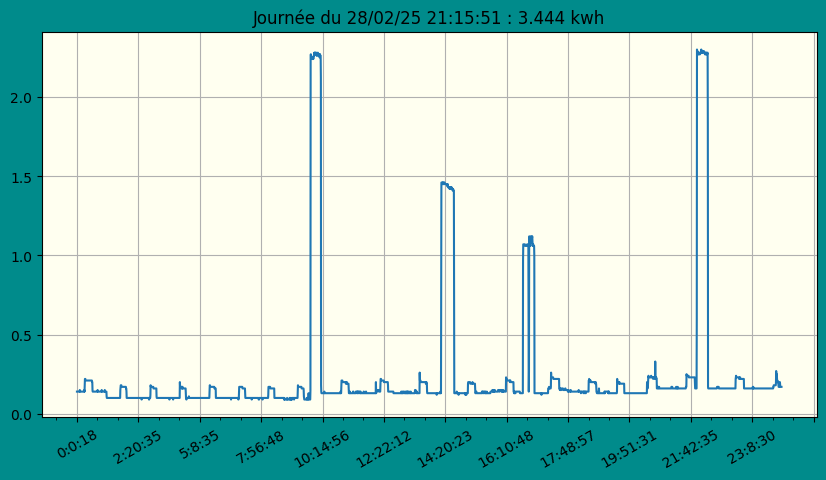

In [1412]:
show('28/02/25')

In [1413]:
end = time.time()
print(end - start)

27.32140851020813


### 1 kWh window in data of one day
#### df = conso_day

In [1414]:
df = conso_day
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
996934,17917,0.20,17.917,200.926494,26077753773,2025-04-13 00:00:15.921404,13/04/25
996935,17340,0.21,17.340,207.612457,26077771113,2025-04-13 00:00:33.261404,13/04/25
996936,16845,0.21,16.845,213.713268,26077787958,2025-04-13 00:00:50.106404,13/04/25
996937,18239,0.20,18.239,197.379242,26077806197,2025-04-13 00:01:08.345404,13/04/25
996938,17797,0.20,17.797,202.281283,26077823994,2025-04-13 00:01:26.142404,13/04/25
...,...,...,...,...,...,...,...
999995,22811,0.16,22.811,157.818596,26154180844,2025-04-13 21:14:02.992404,13/04/25
999996,22358,0.16,22.358,161.016191,26154203202,2025-04-13 21:14:25.350404,13/04/25
999997,21289,0.17,21.289,169.101414,26154224491,2025-04-13 21:14:46.639404,13/04/25
999998,21356,0.17,21.356,168.570893,26154245847,2025-04-13 21:15:07.995404,13/04/25


In [1415]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [1416]:
df = conso_day
len(df)

3066

In [1417]:
period()  # first kWh

2025-04-13 00:00:15.921404	2025-04-13 09:25:21.131404	9h 25m 5s 	1000


In [1418]:
period(p=2) # second period

2025-04-13 09:25:21.131404	2025-04-13 13:39:42.446404	4h 14m 21s 	2000


In [1419]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.291253
dtype: float64

In [1420]:
end = time.time()
print(end - start)

27.65103268623352


## mean for data grouped by days

In [1421]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.30033
dtype: float64

In [1422]:
last=df_grp.iloc[-1]['kWh']
last

np.float64(3.066)

# conso by date


In [1423]:
# select day
day = today

#day = '16/08/24'
day

'13/04/25'

In [1424]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
996934,17917,0.20,17.917,200.926494,26077753773,2025-04-13 00:00:15.921404,13/04/25
996935,17340,0.21,17.340,207.612457,26077771113,2025-04-13 00:00:33.261404,13/04/25
996936,16845,0.21,16.845,213.713268,26077787958,2025-04-13 00:00:50.106404,13/04/25
996937,18239,0.20,18.239,197.379242,26077806197,2025-04-13 00:01:08.345404,13/04/25
996938,17797,0.20,17.797,202.281283,26077823994,2025-04-13 00:01:26.142404,13/04/25
...,...,...,...,...,...,...,...
999995,22811,0.16,22.811,157.818596,26154180844,2025-04-13 21:14:02.992404,13/04/25
999996,22358,0.16,22.358,161.016191,26154203202,2025-04-13 21:14:25.350404,13/04/25
999997,21289,0.17,21.289,169.101414,26154224491,2025-04-13 21:14:46.639404,13/04/25
999998,21356,0.17,21.356,168.570893,26154245847,2025-04-13 21:15:07.995404,13/04/25


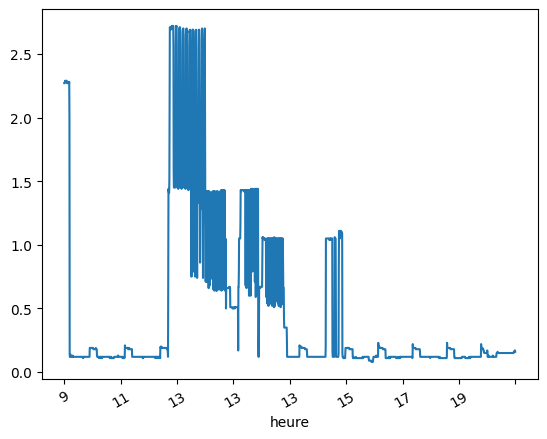

In [1425]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df= conso_day.set_index('heure')
df.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [1426]:
end = time.time()
print(end - start)

28.31722855567932


### grouped by 'heure'

In [1427]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3066 entries, 996934 to 999999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   3066 non-null   int64         
 1   kWh        3066 non-null   float64       
 2   sec        3066 non-null   float64       
 3   Wh         3066 non-null   float64       
 4   cumul(ms)  3066 non-null   int64         
 5   dates      3066 non-null   datetime64[ns]
 6   days       3066 non-null   object        
 7   heure      3066 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 215.6+ KB


In [1428]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
heure,,,,,,,
0,17917,0.20,17.917,200.926494,26077753773,2025-04-13 00:00:15.921404,13/04/25
0,17340,0.21,17.340,207.612457,26077771113,2025-04-13 00:00:33.261404,13/04/25
0,16845,0.21,16.845,213.713268,26077787958,2025-04-13 00:00:50.106404,13/04/25
0,18239,0.20,18.239,197.379242,26077806197,2025-04-13 00:01:08.345404,13/04/25
0,17797,0.20,17.797,202.281283,26077823994,2025-04-13 00:01:26.142404,13/04/25
...,...,...,...,...,...,...,...
21,22811,0.16,22.811,157.818596,26154180844,2025-04-13 21:14:02.992404,13/04/25
21,22358,0.16,22.358,161.016191,26154203202,2025-04-13 21:14:25.350404,13/04/25
21,21289,0.17,21.289,169.101414,26154224491,2025-04-13 21:14:46.639404,13/04/25


In [1429]:
# group by hour, df  = data of a chosen day
df_byhour = df[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', ...], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [1430]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0     107
1     104
2     101
3     102
4     120
5     130
6      99
7     100
8      98
9     154
10    129
11    129
12    118
13    592
14    134
15    175
16    123
17    129
18    117
19    128
20    137
21     40
Name: kWh, dtype: int64

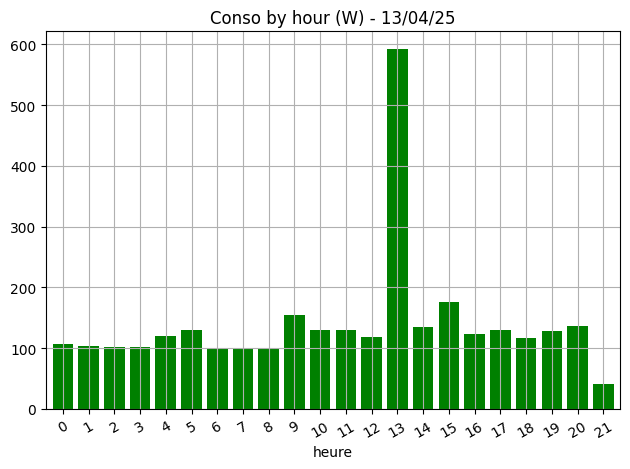

In [1431]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [1432]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 303 entries, 15/06/24 to 13/04/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     303 non-null    float64
dtypes: float64(1)
memory usage: 4.7+ KB


In [1433]:
# give the periods of 1 kwh in a day
period()

2025-04-13 00:00:15.921404	2025-04-13 09:25:21.131404	9h 25m 5s 	1000


In [1434]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
df.iloc[0].dates, df.iloc[1000].dates
#df.dates.dt.time


(Timestamp('2025-04-13 00:00:15.921404'),
 Timestamp('2025-04-13 09:25:43.351404'))

In [1435]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp


In [1436]:
df_grp.mean()


kWh    3.30033
dtype: float64

In [1437]:
df_grp.head()


,kWh
days,
15/06/24,2.337
16/06/24,3.698
17/06/24,3.274
18/06/24,3.106
19/06/24,3.209


In [1438]:
df_grp.tail()


,kWh
days,
09/04/25,3.037
10/04/25,2.496
11/04/25,3.263
12/04/25,2.736
13/04/25,3.066


In [1439]:
end = time.time()
print(end - start)

29.25564455986023


# plot les 100 derniers jours


In [1440]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    3.58013
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

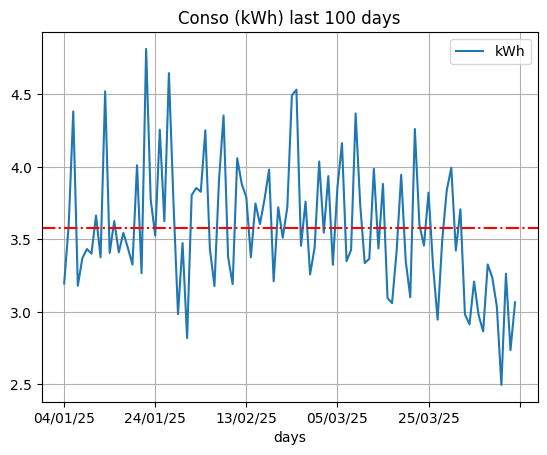

In [1441]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.axhline(y=np.nanmean(df_100),c='red', ls='-.',label='moyenne')
plt.grid()
plt.title('Conso (kWh) last 100 days')


In [1442]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,2.496
max,4.813


In [1443]:
end = time.time()
print(end - start)

29.793125867843628


In [1444]:
df_grp[-31:-1].index[0],df_grp[-31:-1].index[-5]

('14/03/25', '08/04/25')

In [1445]:
moyenne = df_grp.iloc[-31:-1].mean()
moyenne

kWh    3.339467
dtype: float64

Text(0.5, 1.0, 'Last month conso by day')

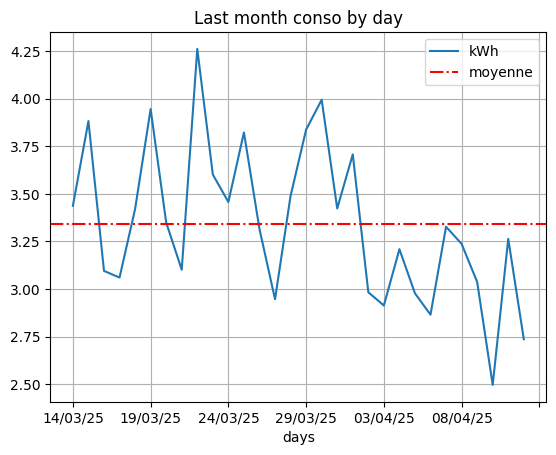

In [1446]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.axhline(y=np.nanmean(df_grp.iloc[-31:-1]),c='red', ls='-.',label='moyenne')
plt.legend()
plt.grid()
plt.title('Last month conso by day')


In [1447]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 22/03/25 4.261
Min : 10/04/25 2.496


# Temps de conso par tranche de 1 kWh

In [1448]:

tranches = len(df)//1000
tranches+1


4

In [1449]:
# temps de conso par tranches de 1kwh
for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
    if len(df)>(p-1)*1000:
        period(p=p)
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


2025-04-13 00:00:15.921404	2025-04-13 09:25:21.131404	9h 25m 5s 	1000
2025-04-13 09:25:21.131404	2025-04-13 13:39:42.446404	4h 14m 21s 	2000
2025-04-13 13:39:42.446404	2025-04-13 20:49:10.168404	7h 9m 27s 	3000
2025-04-13 20:49:10.168404	2025-04-13 21:15:30.399404	0h 26m 20s 	66


('21:15:51', 3.066, 3066)

In [1450]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3066 entries, 996934 to 999999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   3066 non-null   int64         
 1   kWh        3066 non-null   float64       
 2   sec        3066 non-null   float64       
 3   Wh         3066 non-null   float64       
 4   cumul(ms)  3066 non-null   int64         
 5   dates      3066 non-null   datetime64[ns]
 6   days       3066 non-null   object        
 7   heure      3066 non-null   object        
 8   hours      3066 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 239.5+ KB


In [1451]:
conso_hours['heure'], conso_hours['hours']

(996934     0
 996935     0
 996936     0
 996937     0
 996938     0
           ..
 999995    21
 999996    21
 999997    21
 999998    21
 999999    21
 Name: heure, Length: 3066, dtype: object,
 996934    00
 996935    00
 996936    00
 996937    00
 996938    00
           ..
 999995    21
 999996    21
 999997    21
 999998    21
 999999    21
 Name: hours, Length: 3066, dtype: object)

In [1452]:
end = time.time()
print(end - start)

30.437986612319946


# select number of days to display


In [1453]:
span = 30
#df_grp.tail(span)

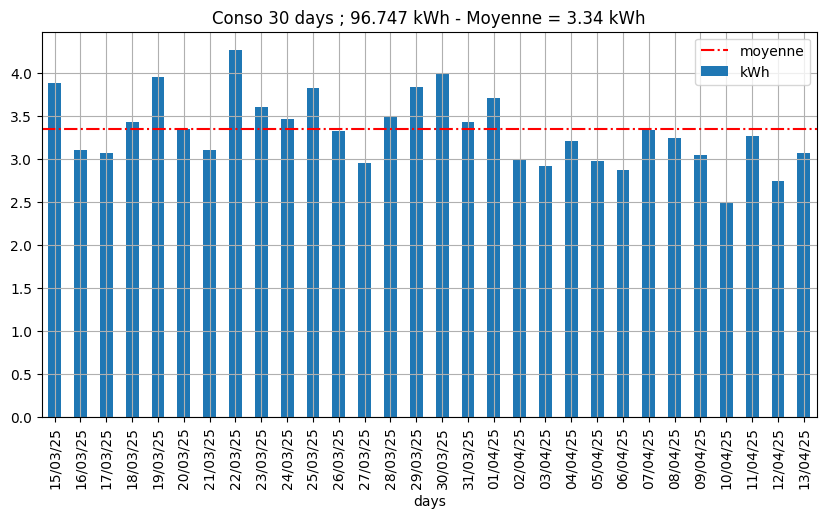

In [1454]:

# Plot the figure without labels
moy = round(np.nanmean(df_grp.tail(span).iloc[-31:-1]),2)
conso_mois = sum(df_grp.tail(span).iloc[-31:-1]['kWh'])
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight')
 
plt.title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
plt.xticks(rotation=90);


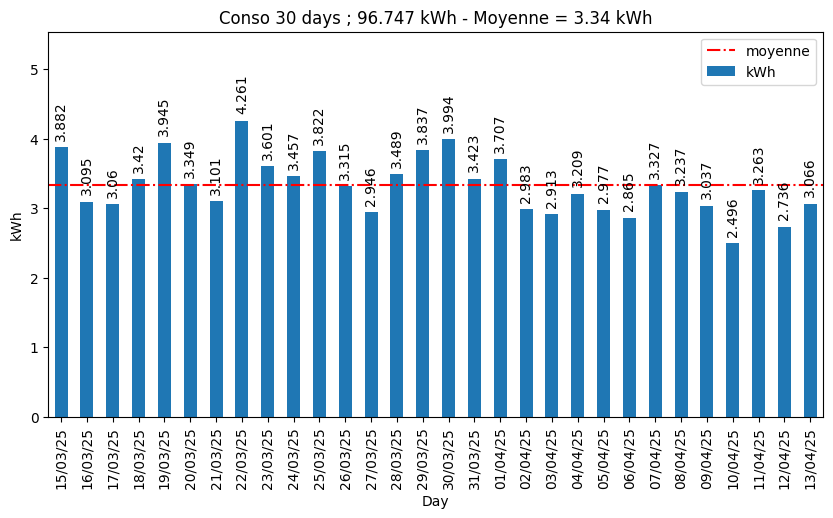

In [1455]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
#ax.set_title(f"Conso by {span} days")
ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [1456]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
15/03/25    3.882
16/03/25    3.095
17/03/25    3.060
18/03/25    3.420
19/03/25    3.945
20/03/25    3.349
21/03/25    3.101
22/03/25    4.261
23/03/25    3.601
24/03/25    3.457
25/03/25    3.822
26/03/25    3.315
27/03/25    2.946
28/03/25    3.489
29/03/25    3.837
30/03/25    3.994
31/03/25    3.423
01/04/25    3.707
02/04/25    2.983
03/04/25    2.913
04/04/25    3.209
05/04/25    2.977
06/04/25    2.865
07/04/25    3.327
08/04/25    3.237
09/04/25    3.037
10/04/25    2.496
11/04/25    3.263
12/04/25    2.736
13/04/25    3.066
Name: kWh, dtype: float64

In [1457]:
x_labels=df_grp.tail(span).index
x_labels

Index(['15/03/25', '16/03/25', '17/03/25', '18/03/25', '19/03/25', '20/03/25',
       '21/03/25', '22/03/25', '23/03/25', '24/03/25', '25/03/25', '26/03/25',
       '27/03/25', '28/03/25', '29/03/25', '30/03/25', '31/03/25', '01/04/25',
       '02/04/25', '03/04/25', '04/04/25', '05/04/25', '06/04/25', '07/04/25',
       '08/04/25', '09/04/25', '10/04/25', '11/04/25', '12/04/25', '13/04/25'],
      dtype='object', name='days')

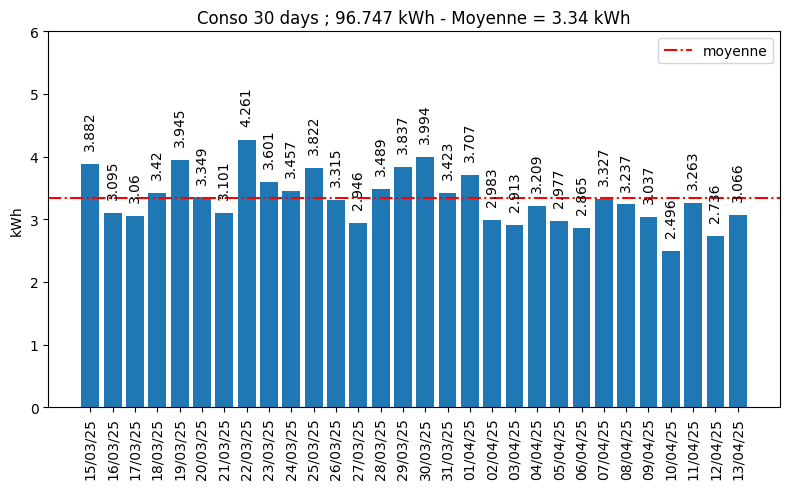

In [1458]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
#ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
ax.set(ylabel='kWh', title=f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh', ylim=(0, 6))
plt.xticks(rotation=90);


In [1459]:
end = time.time()
print(end - start)

33.261688232421875


In [1460]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

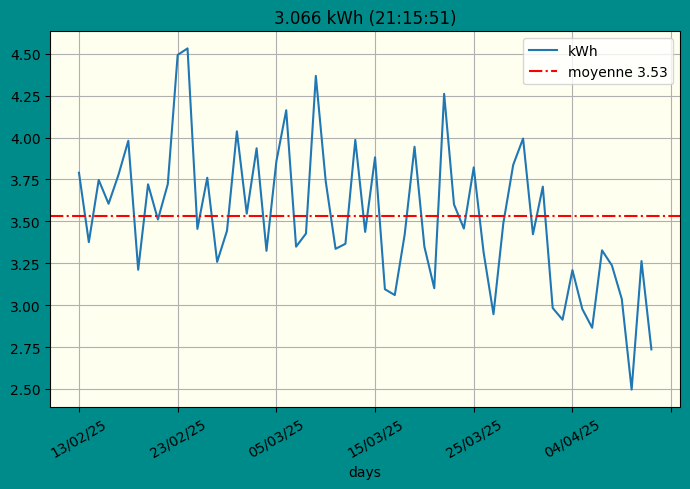

In [1461]:
# 2 last months
scan = 60
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")

moy = round(np.nanmean(df_grp.iloc[-scan:-1]),2)
df_grp.iloc[-scan:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(str(last)+' kWh ('+str(here)+')')
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

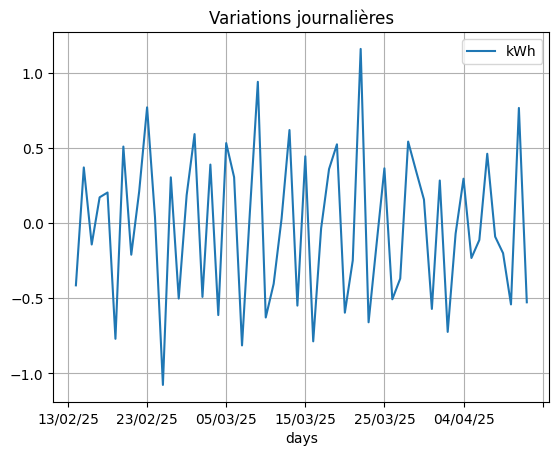

In [1462]:
# variations journalières sur 60 jours
df_grp.iloc[-60:-1].diff().plot(grid=True)
plt.title('Variations journalières')

In [1463]:
end = time.time()
print(end - start)

34.17590594291687


# Data from 21/08/23

In [1464]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')

conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,28184,0.13,28.184,127.732047,28184,2024-06-15 04:11:30.332404,15/06/24,04,2024-06,15
1,28155,0.13,28.155,127.863612,56339,2024-06-15 04:11:58.487404,15/06/24,04,2024-06,15
2,28124,0.13,28.124,128.004551,84463,2024-06-15 04:12:26.611404,15/06/24,04,2024-06,15
3,28416,0.13,28.416,126.689189,112879,2024-06-15 04:12:55.027404,15/06/24,04,2024-06,15
4,28973,0.12,28.973,124.253615,141852,2024-06-15 04:13:24.000404,15/06/24,04,2024-06,15
...,...,...,...,...,...,...,...,...,...,...
999995,22811,0.16,22.811,157.818596,26154180844,2025-04-13 21:14:02.992404,13/04/25,21,2025-04,13
999996,22358,0.16,22.358,161.016191,26154203202,2025-04-13 21:14:25.350404,13/04/25,21,2025-04,13
999997,21289,0.17,21.289,169.101414,26154224491,2025-04-13 21:14:46.639404,13/04/25,21,2025-04,13
999998,21356,0.17,21.356,168.570893,26154245847,2025-04-13 21:15:07.995404,13/04/25,21,2025-04,13


In [1465]:
end = time.time()
print(end - start)

67.4563102722168


In [1466]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)

conso_grouped_by_month.groups.keys()

dict_keys(['2024-06', '2024-07', '2024-08', '2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04'])

# define month to show

<Axes: xlabel='day'>

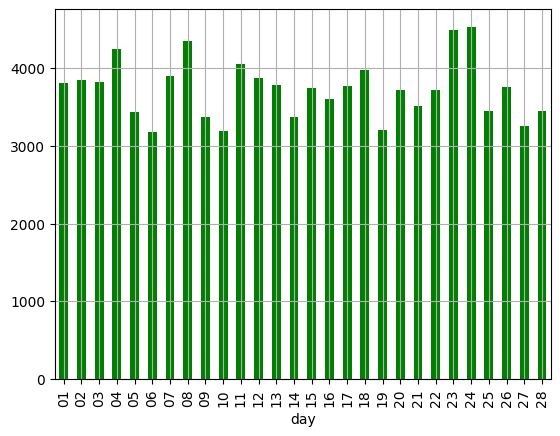

In [1467]:
month=conso_grouped_by_month.get_group('2025-02')
conso_grouped_by_month_day = month.groupby(['day'], sort=False)
conso_grouped_by_month_day['kWh'].count().plot(grid=True,kind='bar',color='green',width=.5)

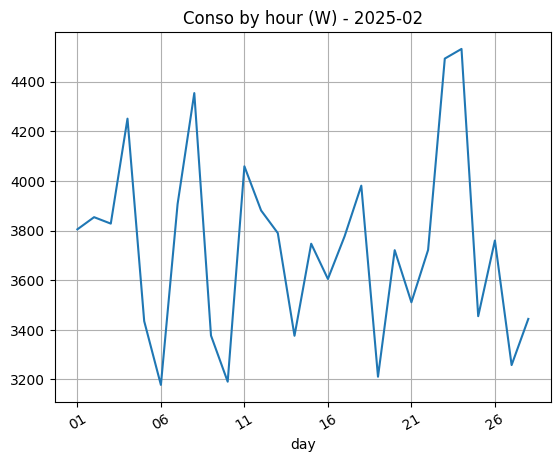

In [1468]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
plt.title('Conso by hour (W) - '+month.iloc[0]['months'])
plt.xticks(rotation=30);


In [1469]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

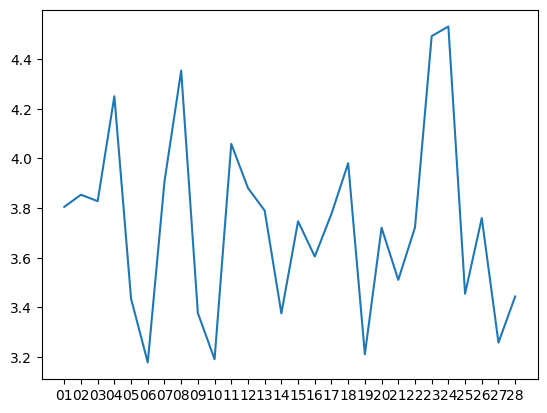

In [1470]:
plt.plot(conso_grouped_by_month_day['kWh'].count()/1000)

In [1471]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [1472]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [1473]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2024-06,47901,47901,47901
2024-07,99397,99397,99397
2024-08,117328,117328,117328
2024-09,69761,69761,69761
2024-10,73533,73533,73533
2024-11,108510,108510,108510
2024-12,113775,113775,113775
2025-01,113607,113607,113607
2025-02,104503,104503,104503


In [1474]:
# example groupby with apply
df = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [1475]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [1476]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
15/06/24,2337
16/06/24,3698
17/06/24,3274
18/06/24,3106
19/06/24,3209
...,...
09/04/25,3037
10/04/25,2496
11/04/25,3263


In [1477]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,28184,0.13,28.184,127.732047,28184,2024-06-15 04:11:30.332404,15/06/24,04,2024-06,15
1,28155,0.13,28.155,127.863612,56339,2024-06-15 04:11:58.487404,15/06/24,04,2024-06,15
2,28124,0.13,28.124,128.004551,84463,2024-06-15 04:12:26.611404,15/06/24,04,2024-06,15
3,28416,0.13,28.416,126.689189,112879,2024-06-15 04:12:55.027404,15/06/24,04,2024-06,15
4,28973,0.12,28.973,124.253615,141852,2024-06-15 04:13:24.000404,15/06/24,04,2024-06,15
...,...,...,...,...,...,...,...,...,...,...
999995,22811,0.16,22.811,157.818596,26154180844,2025-04-13 21:14:02.992404,13/04/25,21,2025-04,13
999996,22358,0.16,22.358,161.016191,26154203202,2025-04-13 21:14:25.350404,13/04/25,21,2025-04,13
999997,21289,0.17,21.289,169.101414,26154224491,2025-04-13 21:14:46.639404,13/04/25,21,2025-04,13
999998,21356,0.17,21.356,168.570893,26154245847,2025-04-13 21:15:07.995404,13/04/25,21,2025-04,13


In [1478]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                             
15/06/24 04    0       15/06/24    04  0.13
               1       15/06/24    04  0.13
               2       15/06/24    04  0.13
               3       15/06/24    04  0.13
               4       15/06/24    04  0.12
...                         ...   ...   ...
13/04/25 21    999995  13/04/25    21  0.16
               999996  13/04/25    21  0.16
               999997  13/04/25    21  0.17
               999998  13/04/25    21  0.17
               999999  13/04/25    21  0.16

[1000000 rows x 3 columns]

In [1479]:
groupallbyday.indices.keys()

dict_keys(['15/06/24', '16/06/24', '17/06/24', '18/06/24', '19/06/24', '20/06/24', '21/06/24', '22/06/24', '23/06/24', '24/06/24', '25/06/24', '26/06/24', '27/06/24', '28/06/24', '29/06/24', '30/06/24', '01/07/24', '02/07/24', '03/07/24', '04/07/24', '05/07/24', '06/07/24', '07/07/24', '08/07/24', '09/07/24', '10/07/24', '11/07/24', '12/07/24', '13/07/24', '14/07/24', '15/07/24', '16/07/24', '17/07/24', '18/07/24', '19/07/24', '20/07/24', '21/07/24', '22/07/24', '23/07/24', '24/07/24', '25/07/24', '26/07/24', '27/07/24', '28/07/24', '29/07/24', '30/07/24', '31/07/24', '01/08/24', '02/08/24', '03/08/24', '04/08/24', '05/08/24', '06/08/24', '07/08/24', '08/08/24', '09/08/24', '10/08/24', '11/08/24', '12/08/24', '13/08/24', '14/08/24', '15/08/24', '16/08/24', '17/08/24', '18/08/24', '19/08/24', '20/08/24', '21/08/24', '22/08/24', '23/08/24', '24/08/24', '25/08/24', '26/08/24', '27/08/24', '28/08/24', '29/08/24', '30/08/24', '31/08/24', '01/09/24', '02/09/24', '03/09/24', '04/09/24', '05/0

In [1480]:
groupallbydayhours.indices.keys()

dict_keys([('15/06/24', '04'), ('15/06/24', '05'), ('15/06/24', '06'), ('15/06/24', '07'), ('15/06/24', '08'), ('15/06/24', '09'), ('15/06/24', '10'), ('15/06/24', '11'), ('15/06/24', '12'), ('15/06/24', '13'), ('15/06/24', '14'), ('15/06/24', '15'), ('15/06/24', '16'), ('15/06/24', '17'), ('15/06/24', '18'), ('15/06/24', '19'), ('15/06/24', '20'), ('15/06/24', '21'), ('15/06/24', '22'), ('15/06/24', '23'), ('16/06/24', '04'), ('16/06/24', '05'), ('16/06/24', '06'), ('16/06/24', '07'), ('16/06/24', '08'), ('16/06/24', '09'), ('16/06/24', '10'), ('16/06/24', '11'), ('16/06/24', '12'), ('16/06/24', '13'), ('16/06/24', '14'), ('16/06/24', '15'), ('16/06/24', '16'), ('16/06/24', '17'), ('16/06/24', '18'), ('16/06/24', '19'), ('16/06/24', '20'), ('16/06/24', '21'), ('16/06/24', '22'), ('16/06/24', '23'), ('16/06/24', '00'), ('16/06/24', '01'), ('16/06/24', '02'), ('16/06/24', '03'), ('17/06/24', '04'), ('17/06/24', '05'), ('17/06/24', '06'), ('17/06/24', '07'), ('17/06/24', '08'), ('17/06/2

In [1481]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
15/06/24,2337,2337
16/06/24,3698,3698
17/06/24,3274,3274
18/06/24,3106,3106
19/06/24,3209,3209
...,...,...
09/04/25,3037,3037
10/04/25,2496,2496
11/04/25,3263,3263


In [1482]:
grp_by_day['kWh'].cumsum()

days
15/06/24       2337
16/06/24       6035
17/06/24       9309
18/06/24      12415
19/06/24      15624
             ...   
09/04/25     988439
10/04/25     990935
11/04/25     994198
12/04/25     996934
13/04/25    1000000
Name: kWh, Length: 303, dtype: int64

In [1483]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
15/06/24 04      91
         05     106
         06     109
         07     118
         08     117
...             ...
13/04/25 17     129
         18     117
         19     128
         20     137
         21      40

[7266 rows x 1 columns]

In [1484]:
grp_by_dayhours['kWh'].cumsum()

days      hours
15/06/24  04            91
          05           197
          06           306
          07           424
          08           541
                    ...   
13/04/25  17        999578
          18        999695
          19        999823
          20        999960
          21       1000000
Name: kWh, Length: 7266, dtype: int64

In [1485]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum  diff
days     hours                   
15/06/24 04      91      91   NaN
         05     106     197  15.0
         06     109     306   3.0
         07     118     424   9.0
         08     117     541  -1.0
...             ...     ...   ...
13/04/25 17     129    2644   6.0
         18     117    2761 -12.0
         19     128    2889  11.0
         20     137    3026   9.0
         21      40    3066 -97.0

[7266 rows x 3 columns]

In [1486]:
today, grp_by_dayhours.loc[today]

('13/04/25',
        kWh  cumsum   diff
 hours                    
 00     107     107    NaN
 01     104     211   -3.0
 02     101     312   -3.0
 03     102     414    1.0
 04     120     534   18.0
 05     130     664   10.0
 06      99     763  -31.0
 07     100     863    1.0
 08      98     961   -2.0
 09     154    1115   56.0
 10     129    1244  -25.0
 11     129    1373    0.0
 12     118    1491  -11.0
 13     592    2083  474.0
 14     134    2217 -458.0
 15     175    2392   41.0
 16     123    2515  -52.0
 17     129    2644    6.0
 18     117    2761  -12.0
 19     128    2889   11.0
 20     137    3026    9.0
 21      40    3066  -97.0)

Text(0.5, 1.0, 'Cumul journalier')

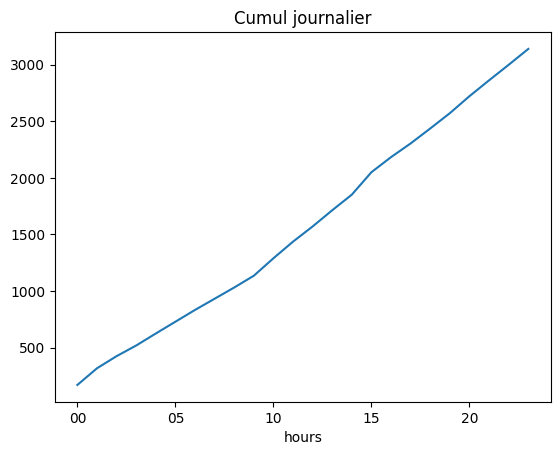

In [1487]:
# progression sans surprise
grp_by_dayhours.loc['05/11/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

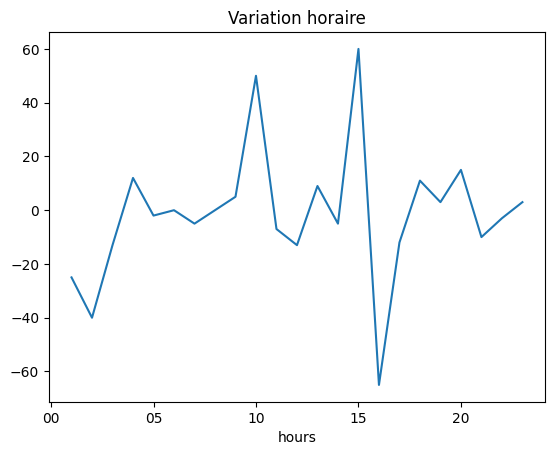

In [1488]:
# plus parlant
grp_by_dayhours.loc['05/11/24']['diff'].plot()
plt.title(r'Variation horaire')

In [1489]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

303

In [1490]:
df_grp.tail(n)['kWh'].describe()


count    303.000000
mean       3.300330
std        0.750532
min        1.783000
25%        3.098000
50%        3.457000
75%        3.786000
max        4.813000
Name: kWh, dtype: float64

In [1491]:
maxday = df_grp.tail(n)['kWh'].idxmax()

In [1492]:
n, np.nanmean(df_grp.tail(n))

(303, np.float64(3.3003300330033))

Text(0.5, 1.0, '303 days')

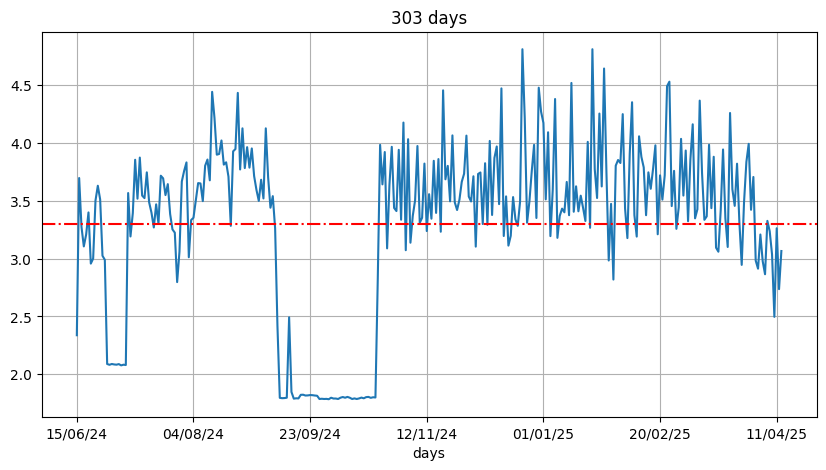

In [1493]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

Text(0.5, 1.0, '100 days')

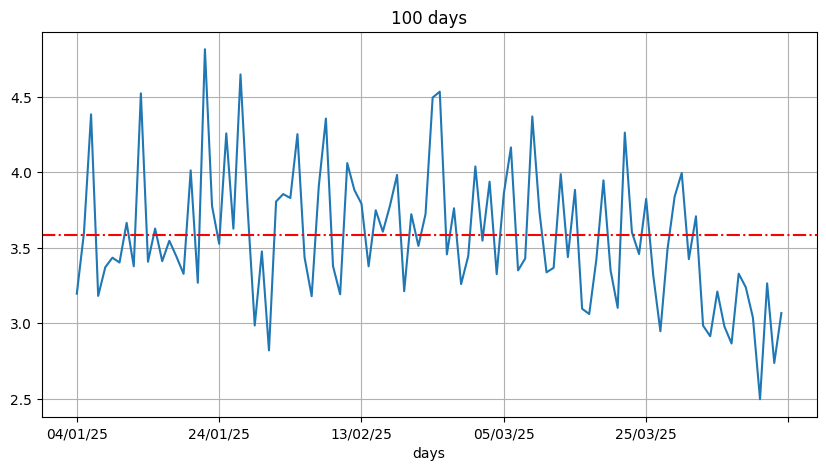

In [1494]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

In [1495]:
np.nanmean(df_grp.tail(span))

np.float64(3.580129999999999)

In [1496]:
df_grp['kWh']

days
15/06/24    2.337
16/06/24    3.698
17/06/24    3.274
18/06/24    3.106
19/06/24    3.209
            ...  
09/04/25    3.037
10/04/25    2.496
11/04/25    3.263
12/04/25    2.736
13/04/25    3.066
Name: kWh, Length: 303, dtype: float64

In [1497]:
df_grp.describe()

,kWh
count,303.000000
mean,3.300330
std,0.750532
min,1.783000
25%,3.098000
50%,3.457000
75%,3.786000
max,4.813000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

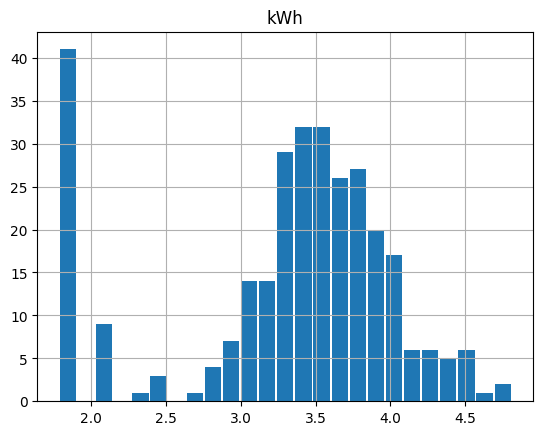

In [1498]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [1499]:
df_grp.tail(span)['kWh']

days
04/01/25    3.195
05/01/25    3.596
06/01/25    4.382
07/01/25    3.180
08/01/25    3.370
            ...  
09/04/25    3.037
10/04/25    2.496
11/04/25    3.263
12/04/25    2.736
13/04/25    3.066
Name: kWh, Length: 100, dtype: float64

# Conso par heure

In [1500]:
day

'13/04/25'

In [1501]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,107,107,NaN
01,104,211,-3.0
02,101,312,-3.0
03,102,414,1.0
04,120,534,18.0
05,130,664,10.0
06,99,763,-31.0
07,100,863,1.0
08,98,961,-2.0


In [1502]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


22

In [1503]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 23)

In [1504]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [1505]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22.])

In [1506]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
14    15.0
15    16.0
16    17.0
17    18.0
18    19.0
19    20.0
20    21.0
21    22.0
Name: days, dtype: float64

In [1507]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [1508]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 22 entries, 00 to 21
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     22 non-null     int64  
 1   cumsum  22 non-null     int64  
 2   diff    21 non-null     float64
 3   days    22 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 880.0+ bytes


In [1509]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
13    14.0
14    15.0
15    16.0
16    17.0
17    18.0
18    19.0
19    20.0
20    21.0
21    22.0
Name: days, dtype: float64

In [1510]:
day

'13/04/25'

In [1511]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,107,107,NaN,1.0
01,104,211,-3.0,2.0
02,101,312,-3.0,3.0
03,102,414,1.0,4.0
04,120,534,18.0,5.0
05,130,664,10.0,6.0
06,99,763,-31.0,7.0
07,100,863,1.0,8.0
08,98,961,-2.0,9.0


In [1512]:
kwh = grp_by_dayhours.loc[day][['kWh']]
np.sum(kwh)[0]


c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\jeand\AppData\Local\Temp\ipykernel_6056\3891495459.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.sum(kwh)[0]


np.int64(3066)

c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Text(0.5, 1.0, '13/04/25: kWh    3066\ndtype: int64')

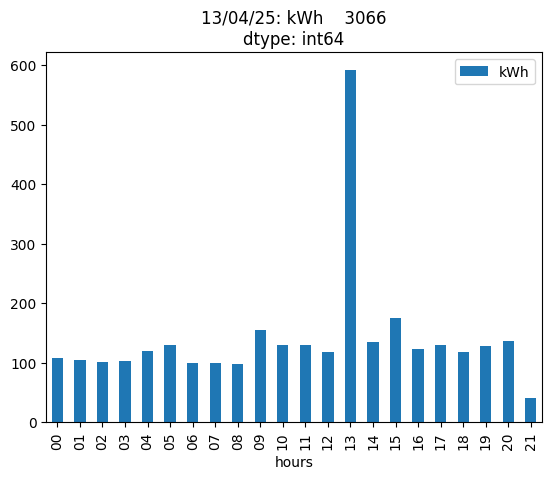

In [1513]:
kwh.plot.bar()
plt.title(f'{day}: {np.sum(kwh)}')

In [1514]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21'],
      dtype='object', name='hours')

# Conso du jour


In [1515]:

grp_by_dayhours.count()

kWh       7266
cumsum    7266
diff      6963
days        22
dtype: int64

'23/12/24'

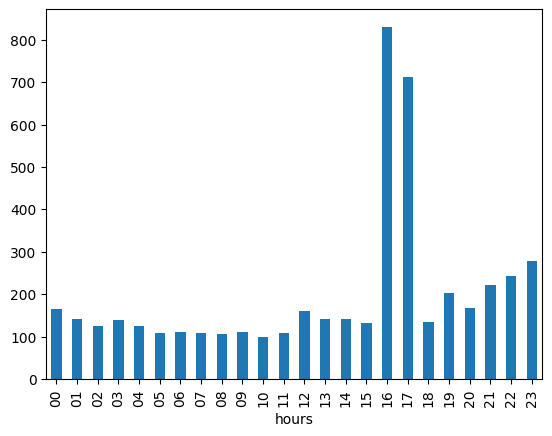

In [1516]:
#day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh.plot(kind='bar')
maxday

In [1517]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

In [1518]:
df_grp.tail(7)['kWh']

days
07/04/25    3.327
08/04/25    3.237
09/04/25    3.037
10/04/25    2.496
11/04/25    3.263
12/04/25    2.736
13/04/25    3.066
Name: kWh, dtype: float64

Total= 358.013 , Moyenne= 3.580129999999999


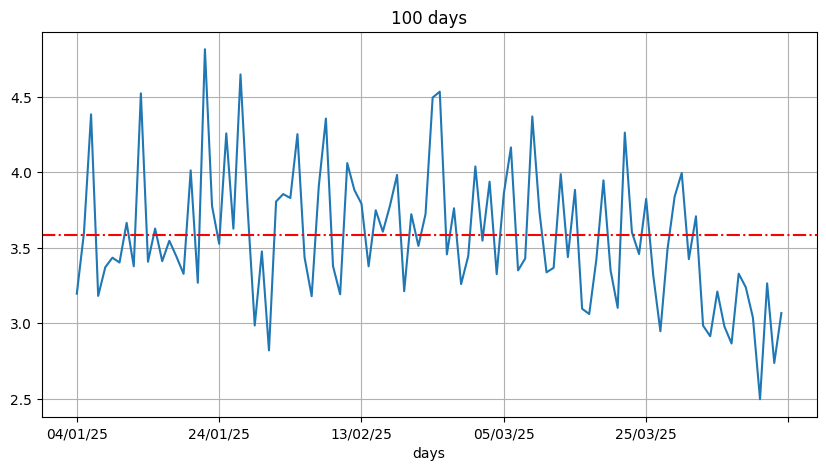

In [1519]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

print('Total=',sum(df_grp.tail(span)['kWh']),', Moyenne=',np.nanmean(df_grp.tail(span)))

In [1520]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(end - start)

79.50791907310486


# Today

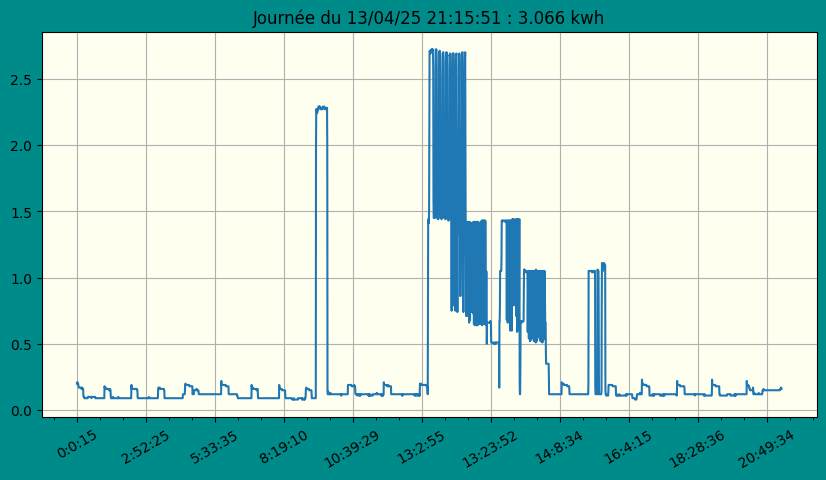

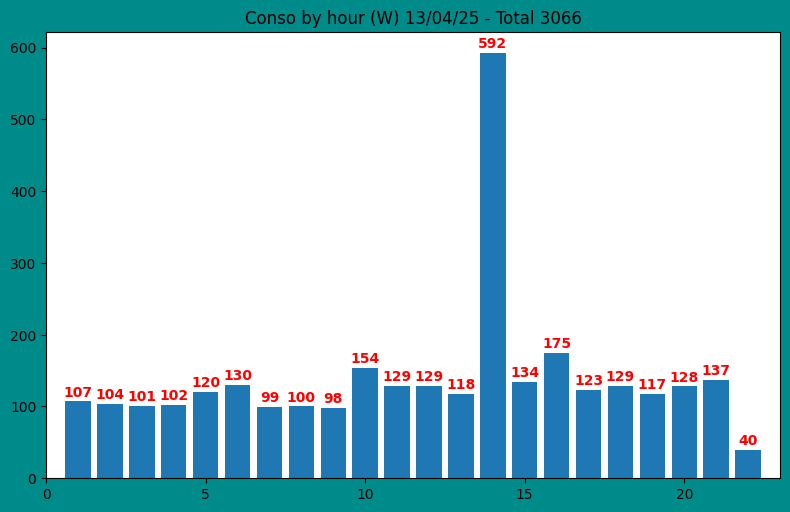

In [1521]:
show(today,bgcolor='ivory')
conso_by_hour(today)

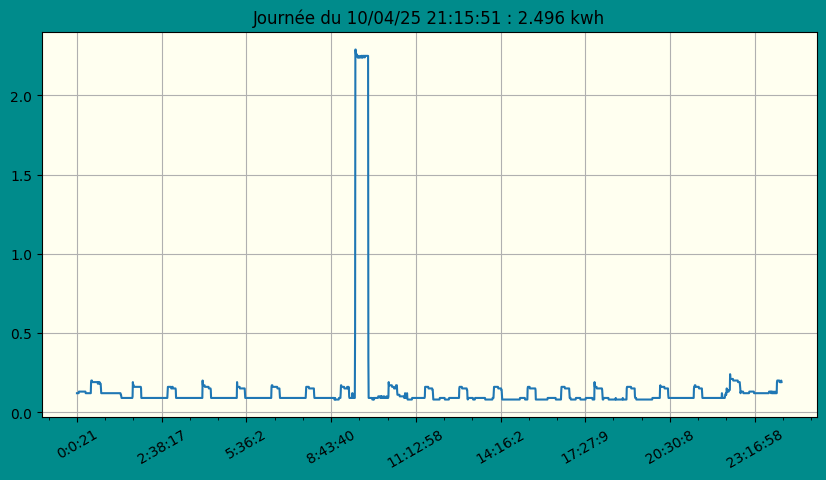

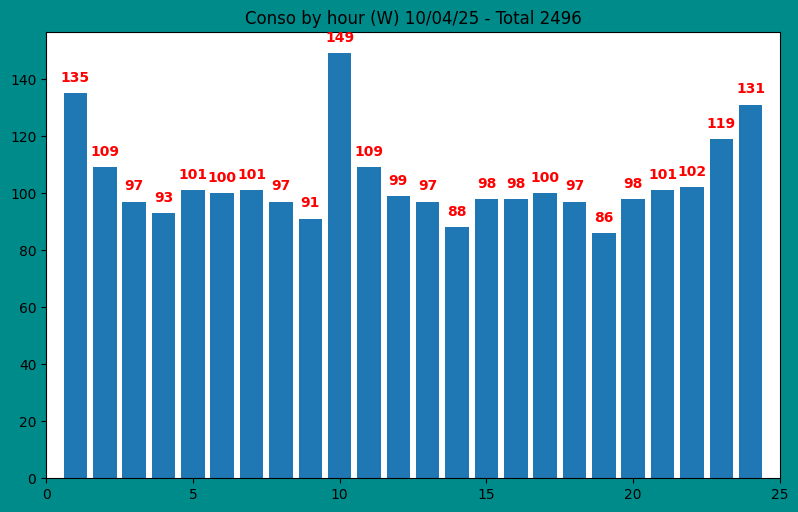

In [1522]:
day = '10/04/25'
day, show(day,bgcolor='ivory')
conso_by_hour(day)

23/12/24


(None, 4813)

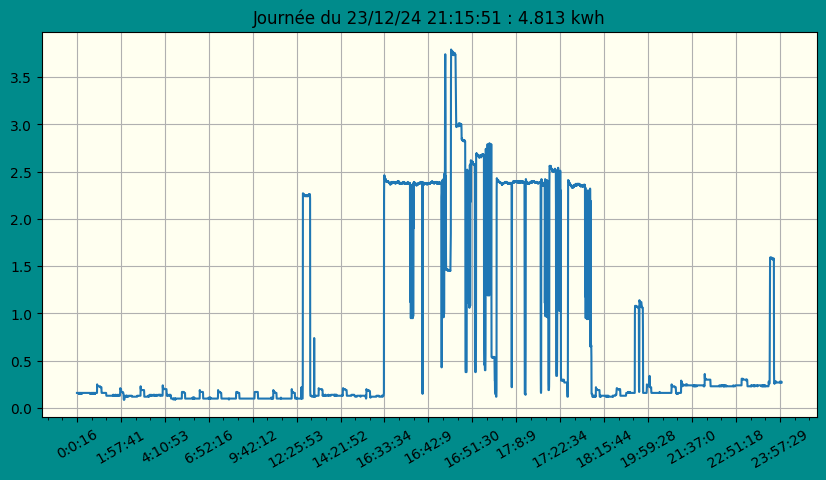

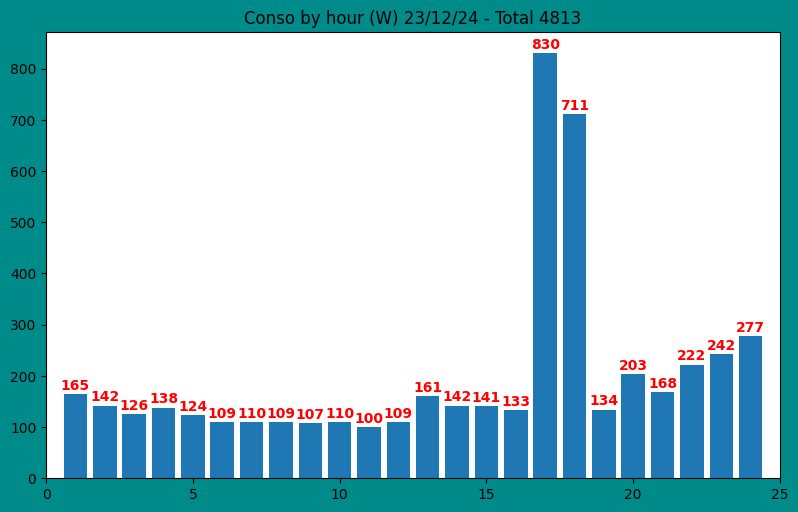

In [1523]:
print(maxday)
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')
conso_by_hour(day),sum(data)

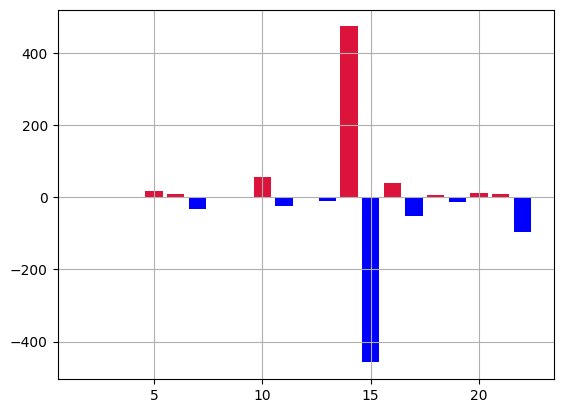

In [1524]:
diff = grp_by_dayhours.loc[today]
diff

x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

<Axes: xlabel='hours'>

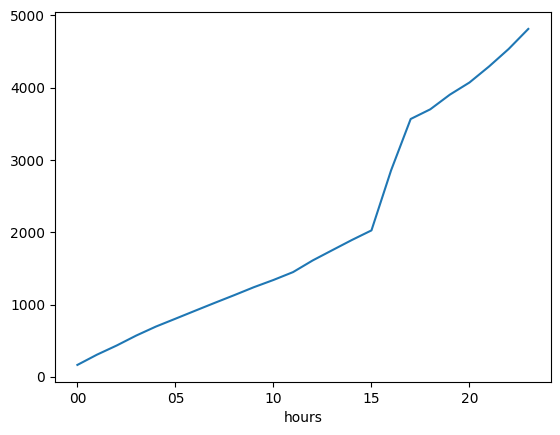

In [1525]:
data.cumsum().plot()


<Axes: xlabel='hours'>

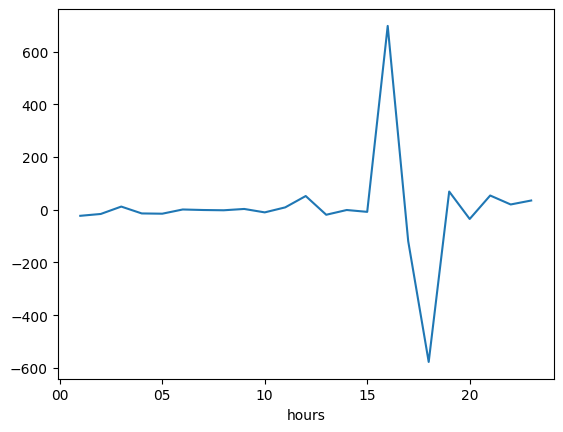

In [1526]:
# evolution par heure
data.diff().plot()

In [1527]:
data.diff().describe()

count     23.000000
mean       4.869565
std      196.278629
min     -577.000000
25%      -15.500000
50%       -1.000000
75%       16.000000
max      697.000000
Name: kWh, dtype: float64

<Axes: >

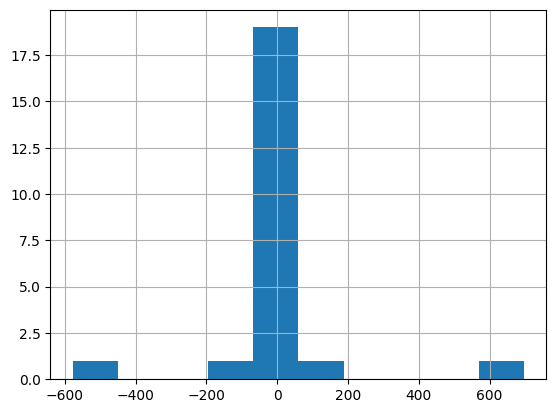

In [1528]:
data.diff().hist()

# Test sauvegarde

# list files in current directory


In [1529]:
import os
os.listdir(path='.')

['linear combination of atomic orbitals.ipynb',
 'loi_pareto.ipynb',
 'Lotka_Volterra_model.ipynb',
 'bitcoin_api.ipynb',
 'pencil_sketch.ipynb',
 'sample.json',
 'tricks.ipynb',
 'pandas_course2.ipynb',
 'socket_server.ipynb',
 'tree_minmax.ipynb',
 'amlich_data.py',
 'decimals_pi_plot.ipynb',
 'conso_jour.csv',
 'Mass_Spring_Damper.jpg',
 'mills_primes.ipynb',
 'ligue1_pandas.ipynb',
 'primes2million.pkl',
 'socket_client.ipynb',
 'magic_tricks.ipynb',
 'magicdragon.ipynb',
 'rainbow_color.ipynb',
 'snake_game.ipynb',
 'sympy_fun.ipynb',
 'tqdm_benchmark.ipynb',
 'ligue1_2020_extended.txt',
 'pd_grp_plot.ipynb',
 'tkinter_scale_color.ipynb',
 'Dewpoint-RH-fr.svg.png',
 'read_xml.ipynb',
 'pi_from_collisions.ipynb',
 'mqtt_temp.ipynb',
 'sudoku_generator.ipynb',
 'onecall_issue.ipynb',
 'poo_chap10.ipynb',
 'table-indicateurs-open-data-france-2023-06-30-17h59.csv',
 'primes12million.pkl',
 'espace_de_phase.ipynb',
 'ipinfo_test.ipynb',
 'enigma_settings.json',
 '__pycache__',
 'test_c

# list store files csv


In [1530]:
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

conso_jour.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
CAC40.csv
Nasdaq.csv
karaoke.csv
saturn_rings.csv
DowJones.csv
planete.csv
conso_par_jour.csv
8days.csv
SMSSpamCollection.csv
df_grp.csv
Ford.csv
Tesla.csv
Nikkei.csv
temp_humidity.csv
titanic.csv
data_temp16122022.csv
week.csv
Toyota.csv
Apple.csv
VNDUSD.csv
demain.csv
saturn_bodies.csv
conso_day_from_20230821.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
ligue1_2020_27.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
conso_data.csv
EURUSD.csv
df.csv


('23/12/24', None)

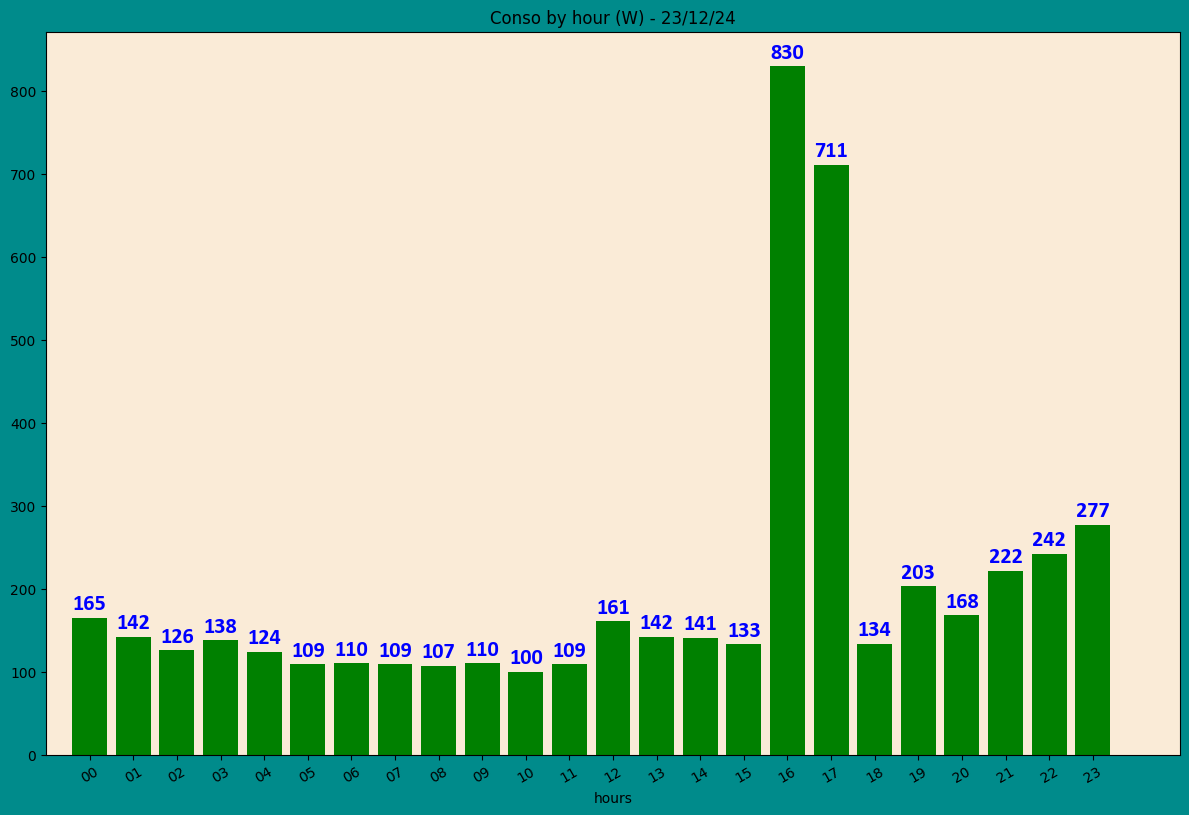

In [1531]:
day,conso_byhour(day)

In [1532]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


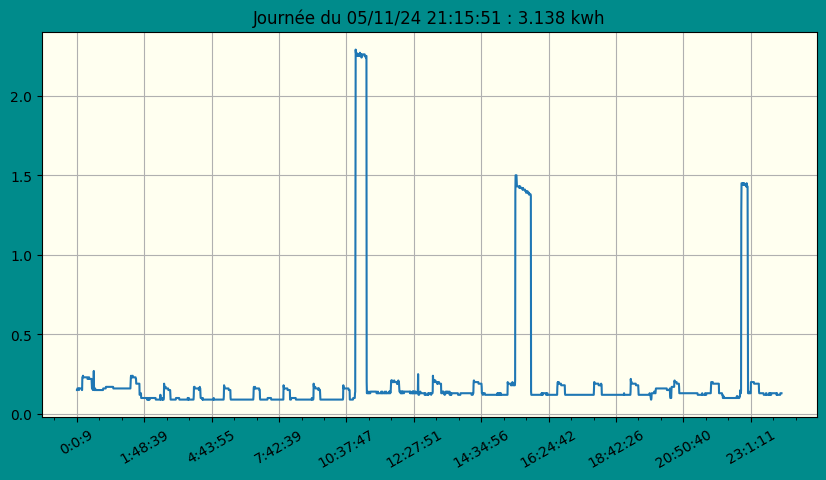

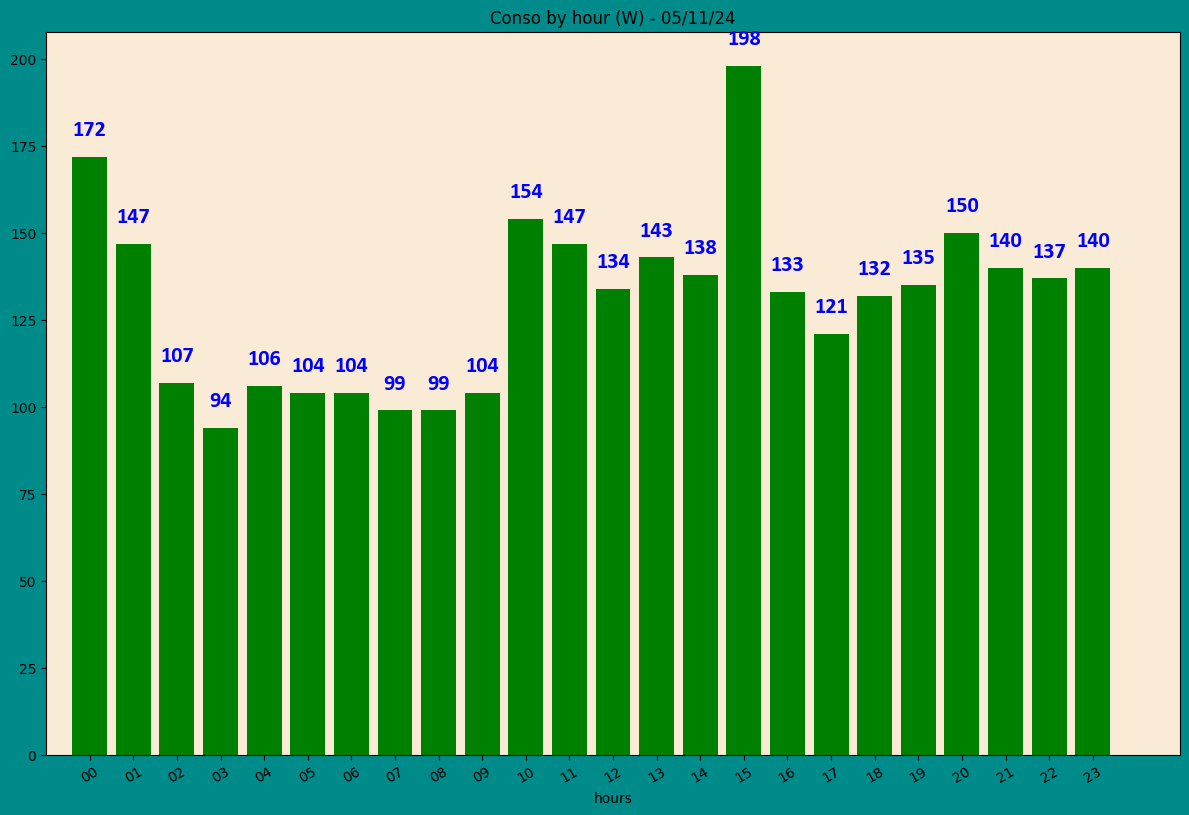

In [1533]:
day = '05/11/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [1534]:
month

,day,hours,months,kWh
743812,01,00,2025-02,0.10
743813,01,00,2025-02,0.10
743814,01,00,2025-02,0.09
743815,01,00,2025-02,0.09
743816,01,00,2025-02,0.09
...,...,...,...,...
848310,28,23,2025-02,0.17
848311,28,23,2025-02,0.17
848312,28,23,2025-02,0.17
848313,28,23,2025-02,0.17


In [1535]:
month.describe()


,kWh
count,104503.000000
mean,0.334552
std,0.555045
min,0.090000
25%,0.120000
50%,0.140000
75%,0.190000
max,3.650000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

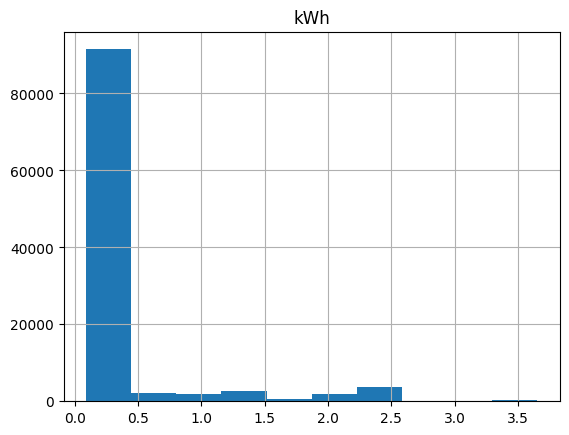

In [1536]:
month.hist()

<Axes: >

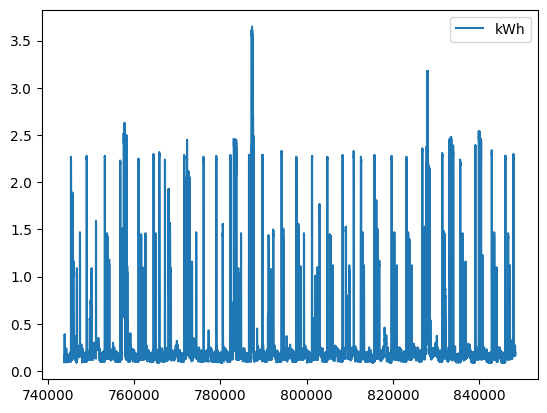

In [1537]:
month.plot()

In [1538]:
# index with max conso in this month
month.idxmax().kWh

np.int64(787329)

In [1539]:
# plot month day max conso (télévision de 11h à 23h)
day_idx = month.idxmax()
#day = '27/10/2024'
day_idx

day       844871
hours     747406
months    743812
kWh       787329
dtype: int64

In [1540]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [1541]:
grp_by_dayhours

kWh  cumsum  diff  days
days     hours                         
15/06/24 04      91      91   NaN   NaN
         05     106     197  15.0   NaN
         06     109     306   3.0   NaN
         07     118     424   9.0   NaN
         08     117     541  -1.0   NaN
...             ...     ...   ...   ...
13/04/25 17     129    2644   6.0  18.0
         18     117    2761 -12.0  19.0
         19     128    2889  11.0  20.0
         20     137    3026   9.0  21.0
         21      40    3066 -97.0  22.0

[7266 rows x 4 columns]

In [1542]:
month

,day,hours,months,kWh
743812,01,00,2025-02,0.10
743813,01,00,2025-02,0.10
743814,01,00,2025-02,0.09
743815,01,00,2025-02,0.09
743816,01,00,2025-02,0.09
...,...,...,...,...
848310,28,23,2025-02,0.17
848311,28,23,2025-02,0.17
848312,28,23,2025-02,0.17
848313,28,23,2025-02,0.17


In [1543]:
month.idxmax()


day       844871
hours     747406
months    743812
kWh       787329
dtype: int64

In [1544]:
month.loc[month.idxmax().kWh]


day            12
hours          15
months    2025-02
kWh          3.65
Name: 787329, dtype: object

In [1545]:
grp_by_dayhours.loc[['28/02/25']].kWh

days      hours
28/02/25  00       151
          01       114
          02       105
          03       106
          04       110
          05       111
          06       101
          07       108
          08       110
          09       109
          10       177
          11       141
          12       149
          13       145
          14       195
          15       141
          16       195
          17       159
          18       149
          19       143
          20       159
          21       226
          22       174
          23       166
Name: kWh, dtype: int64

In [1546]:
max_hour = grp_by_dayhours.loc[['28/02/25']].kWh.idxmax()[1]
max_hour

'21'

<Axes: xlabel='days,hours'>

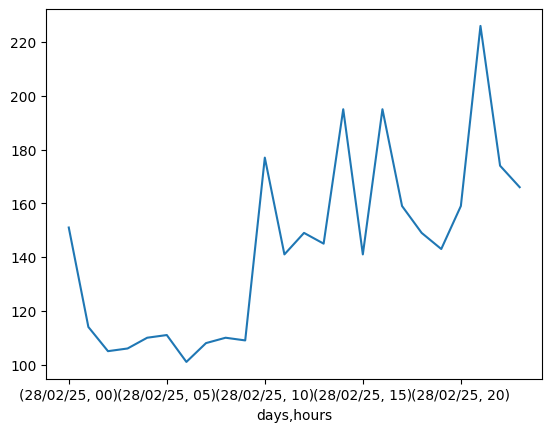

In [1547]:
grp_by_dayhours.loc[['28/02/25']].kWh.plot()#.idxmax()

In [1548]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [1549]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [1550]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [1551]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB